In [18]:
# Import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox



# Suppress warnings
warnings.filterwarnings('ignore')

# For plotting inline
%matplotlib inline


## Data Transformation

In [19]:
# Loading the .csv data as Pandas DataFrame
df = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/onlinefoods.csv')

In [20]:
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes


In [21]:
# Replace specific income ranges with numeric values in the 'Monthly Income' column
df['Monthly Income'].replace(
    ['No Income', 'Below Rs.10000', 'More than 50000', '10001 to 25000', '25001 to 50000'],
    [0, 10000, 50000, 25000, 49999],
    inplace=True
)

# Convert 'Monthly Income' to numeric type
df['Monthly Income'] = pd.to_numeric(df['Monthly Income'])

df.drop('Unnamed: 12', axis=1, inplace=True)

In [22]:
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback
0,20,Female,Single,Student,0,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive
1,24,Female,Single,Student,10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive
2,22,Male,Single,Student,10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative
3,22,Female,Single,Student,0,Graduate,6,12.9473,77.5616,560019,Yes,Positive
4,22,Male,Single,Student,10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive


### Handling Outliers

<Figure size 1400x1800 with 0 Axes>

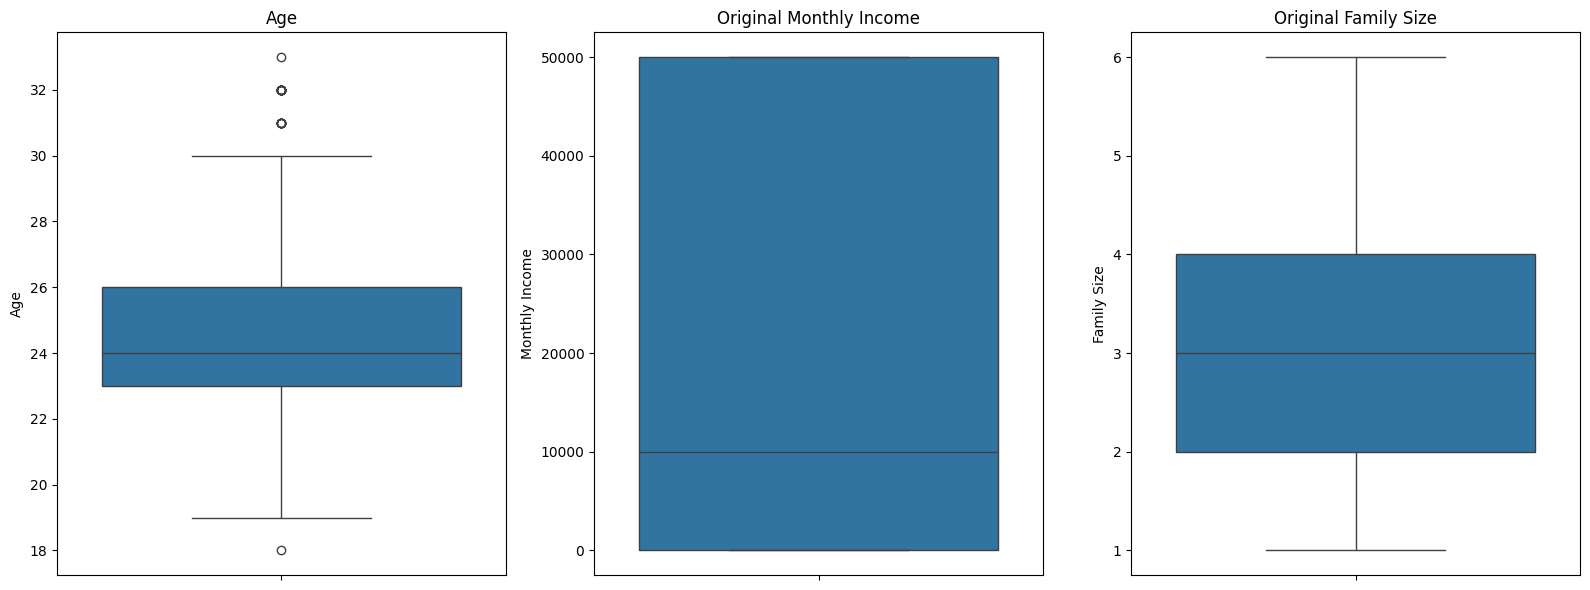

In [23]:
plt.figure(figsize=(14, 18))

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Boxplot for 'Age'
sns.boxplot(y=df['Age'], ax=axes[0])
axes[0].set_title('Age')
axes[0].set_ylabel('Age')

# Boxplot for 'Monthly Income'
sns.boxplot(y=df['Monthly Income'], ax=axes[1])
axes[1].set_title('Original Monthly Income')
axes[1].set_ylabel('Monthly Income')

# Boxplot for 'Family Size'
sns.boxplot(y=df['Family size'], ax=axes[2])
axes[2].set_title('Original Family Size')
axes[2].set_ylabel('Family Size')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


Age has some outliers

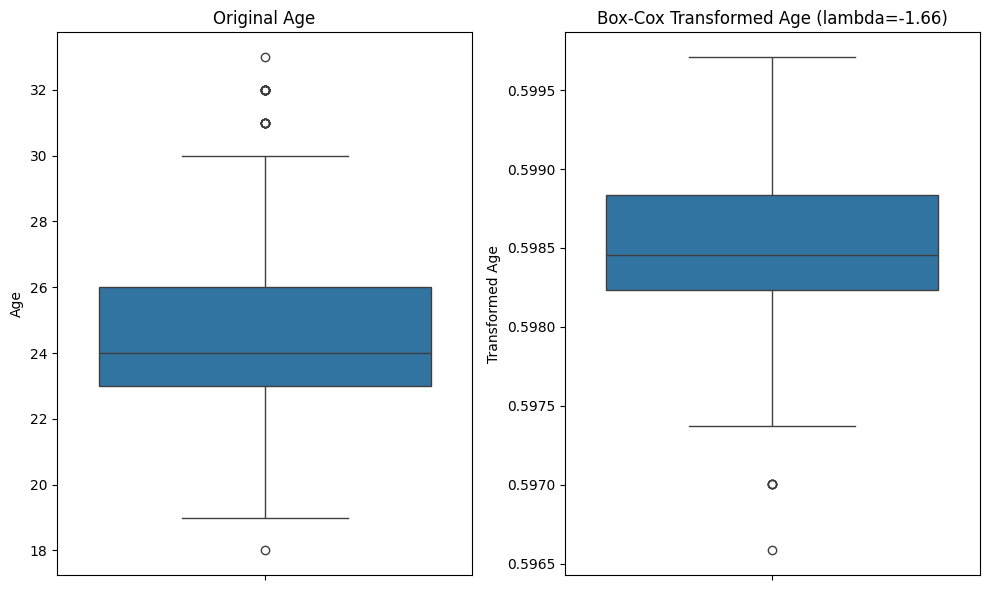

In [24]:
# Applying the Box-Cox transformation
transformed_age, lambda_age = boxcox(df['Age'])

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Boxplot for 'Age'
sns.boxplot(y=df['Age'], ax=axes[0])
axes[0].set_title('Original Age')
axes[0].set_ylabel('Age')

sns.boxplot(y=transformed_age, ax=axes[1])
axes[1].set_title(f'Box-Cox Transformed Age (lambda={lambda_age:.2f})')
axes[1].set_ylabel('Transformed Age')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


### Features Encoding

In [25]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define feature types
num_features = ['Age', 'Monthly Income', 'Family size', 'latitude', 'longitude', 'Pin code']
cat_features = ['Gender', 'Marital Status', 'Occupation', 'Educational Qualifications', 'Feedback', 'Output']

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Create Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

# Apply transformations
transformed_df = preprocessor.fit_transform(df)

# Convert to DataFrame with appropriate column names
num_transformed = pd.DataFrame(transformed_df[:, :len(num_features)], columns=num_features)
cat_transformed = pd.DataFrame(transformed_df[:, len(num_features):], columns=preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_features))

# Concatenate transformed features
encoded_df = pd.concat([num_transformed, cat_transformed], axis=1)

# Display the result of encoding
print("Encoded DataFrame:")
print(encoded_df.head())


Encoded DataFrame:
        Age  Monthly Income  Family size  latitude  longitude  Pin code  \
0 -1.333333       -0.200004          0.5 -0.006653   0.109714 -0.567686   
1  0.000000        0.000000          0.0  0.000000  -0.225524 -0.427948   
2 -0.666667        0.000000          0.0 -0.364241   1.024000 -0.288210   
3 -0.666667       -0.200004          1.5 -0.493971  -0.464762 -0.253275   
4 -0.666667        0.000000          0.5  0.133056  -0.591238 -0.410480   

   Gender_Male  Marital Status_Prefer not to say  Marital Status_Single  \
0          0.0                               0.0                    1.0   
1          0.0                               0.0                    1.0   
2          1.0                               0.0                    1.0   
3          0.0                               0.0                    1.0   
4          1.0                               0.0                    1.0   

   Occupation_House wife  Occupation_Self Employeed  Occupation_Student  \
0   

### Multicollinearity Treatment Using Variance Inflation Factor (VIF)

In [26]:
encoded_df.columns

Index(['Age', 'Monthly Income', 'Family size', 'latitude', 'longitude',
       'Pin code', 'Gender_Male', 'Marital Status_Prefer not to say',
       'Marital Status_Single', 'Occupation_House wife',
       'Occupation_Self Employeed', 'Occupation_Student',
       'Educational Qualifications_Ph.D',
       'Educational Qualifications_Post Graduate',
       'Educational Qualifications_School',
       'Educational Qualifications_Uneducated', 'Feedback_Positive',
       'Output_Yes'],
      dtype='object')

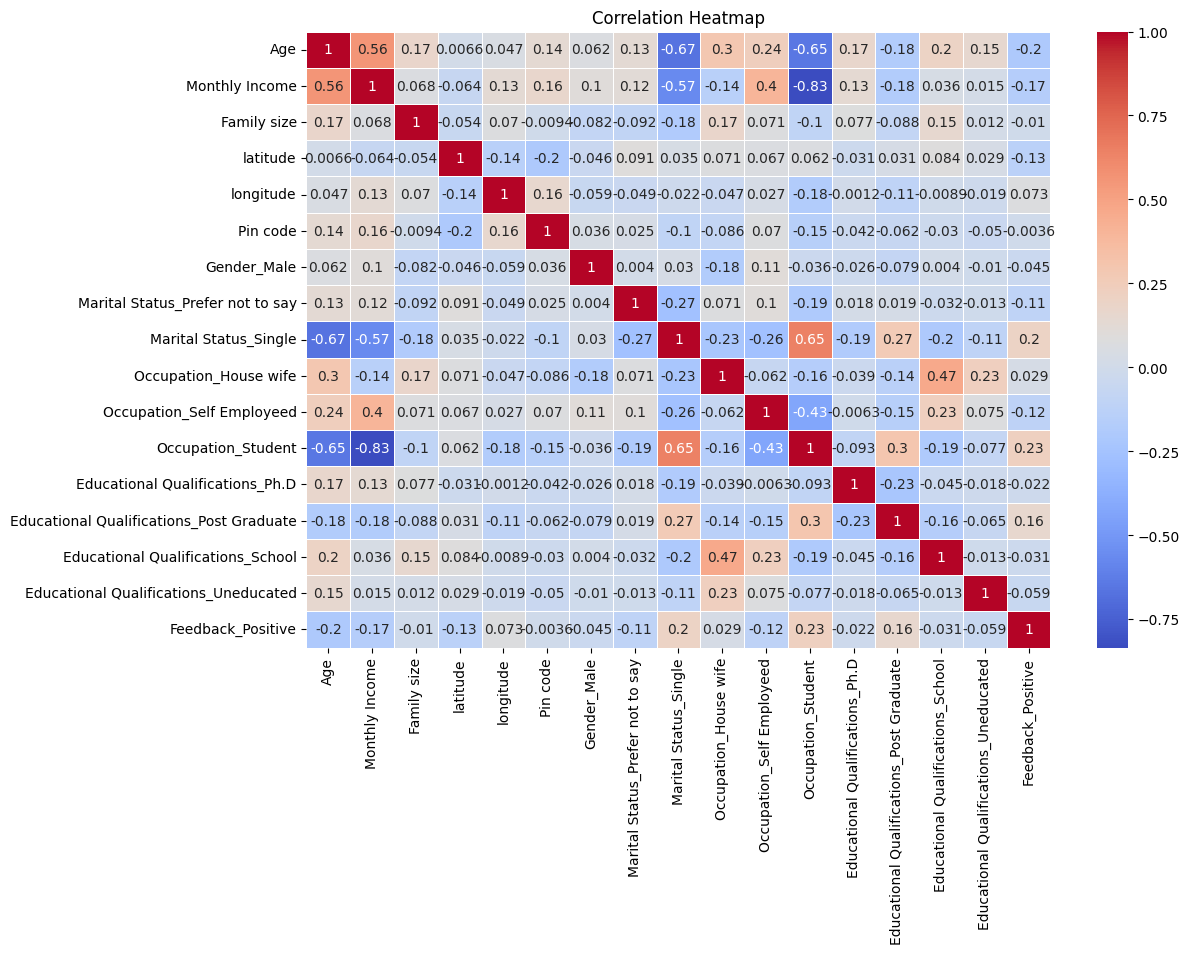

In [27]:
# Remove target variable from the DataFrame used for correlation calculation
features_only = encoded_df.drop(columns=['Output_Yes'])

# Compute correlation matrix
corr = features_only.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [28]:
# Multicollinearity Treatment Using Variance Inflation Factor (VIF)
def calculate_vif(X):
    """
    Calculate VIF for each feature in the DataFrame.
    """
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Calculate VIF for the features
vif_df = calculate_vif(features_only)

# Print the VIF values
print("VIF values:")
print(vif_df)


VIF values:
                                     Feature       VIF
0                                        Age  2.349443
1                             Monthly Income  3.720351
2                                Family size  1.152869
3                                   latitude  1.135908
4                                  longitude  1.147610
5                                   Pin code  1.162402
6                                Gender_Male  2.501602
7           Marital Status_Prefer not to say  1.140601
8                      Marital Status_Single  6.320595
9                      Occupation_House wife  1.995322
10                 Occupation_Self Employeed  1.583484
11                        Occupation_Student  8.273885
12           Educational Qualifications_Ph.D  1.207640
13  Educational Qualifications_Post Graduate  2.317354
14         Educational Qualifications_School  1.542900
15     Educational Qualifications_Uneducated  1.128578
16                         Feedback_Positive  5.59679

In [29]:
# Identify features with high VIF (typically VIF > 5 indicates multicollinearity)
high_vif_features = vif_df[vif_df['VIF'] > 5]['Feature']

high_vif_features

8     Marital Status_Single
11       Occupation_Student
16        Feedback_Positive
Name: Feature, dtype: object

In [30]:
# Drop features with high VIF from the DataFrame
final_df = encoded_df.drop(high_vif_features, axis=1, errors='ignore')

print(f'Features with high Variance Inflation Factor, hence need to be dropped are: \n\n{high_vif_features}')

# Display the final DataFrame after VIF filtering
print("Filtered DataFrame:")
print(final_df.head())

Features with high Variance Inflation Factor, hence need to be dropped are: 

8     Marital Status_Single
11       Occupation_Student
16        Feedback_Positive
Name: Feature, dtype: object
Filtered DataFrame:
        Age  Monthly Income  Family size  latitude  longitude  Pin code  \
0 -1.333333       -0.200004          0.5 -0.006653   0.109714 -0.567686   
1  0.000000        0.000000          0.0  0.000000  -0.225524 -0.427948   
2 -0.666667        0.000000          0.0 -0.364241   1.024000 -0.288210   
3 -0.666667       -0.200004          1.5 -0.493971  -0.464762 -0.253275   
4 -0.666667        0.000000          0.5  0.133056  -0.591238 -0.410480   

   Gender_Male  Marital Status_Prefer not to say  Occupation_House wife  \
0          0.0                               0.0                    0.0   
1          0.0                               0.0                    0.0   
2          1.0                               0.0                    0.0   
3          0.0                        

### Treating Class Imbalance Using SMOTETomek

In [31]:
final_df['Output'] = final_df['Output_Yes']

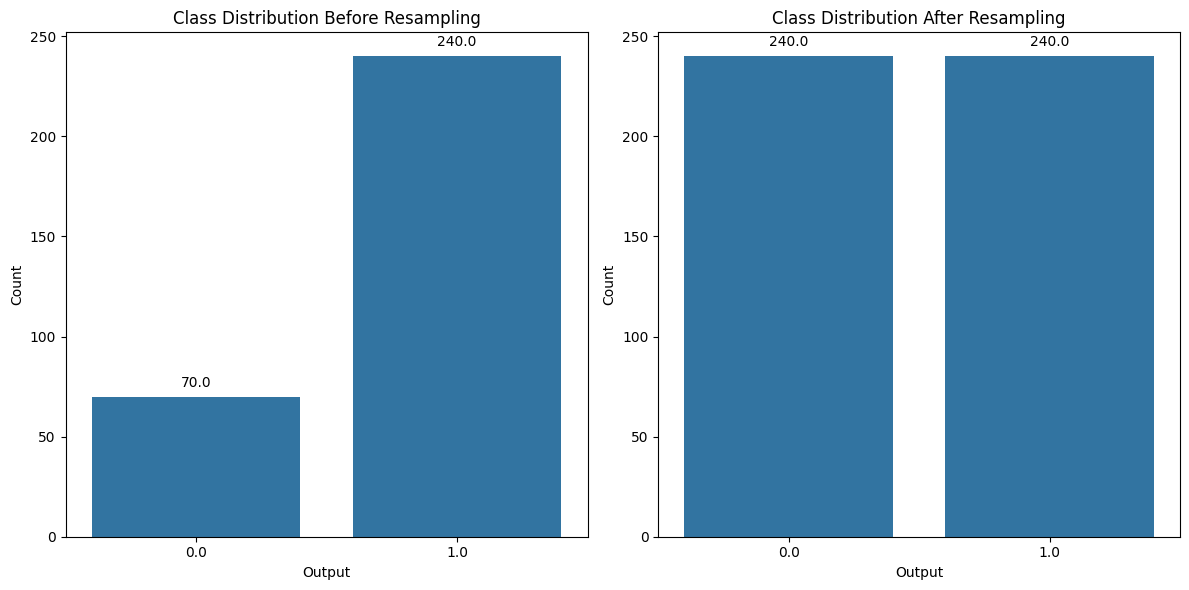

Before resampling:
Output
1.0    240
0.0     70
Name: count, dtype: int64

After resampling:
Output
1.0    240
0.0    240
Name: count, dtype: int64


In [32]:
# Handling Class Imbalance Using SMOTETomek
X = final_df.drop(['Output'], axis=1)  # Features
y = final_df['Output']               # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the SMOTETomek object
smotetomek = SMOTETomek(random_state=42)

# Resample the training data
X_resampled, y_resampled = smotetomek.fit_resample(X_train, y_train)

# Visualize the class distribution before and after resampling
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before resampling
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Class Distribution Before Resampling')
axes[0].set_xlabel('Output')
axes[0].set_ylabel('Count')

# Annotate bars
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# After resampling
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Class Distribution After Resampling')
axes[1].set_xlabel('Output')
axes[1].set_ylabel('Count')

# Annotate bars
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# To verify the balancing effect, check the class distribution
print("Before resampling:")
print(y_train.value_counts())

print("\nAfter resampling:")
print(pd.Series(y_resampled).value_counts())

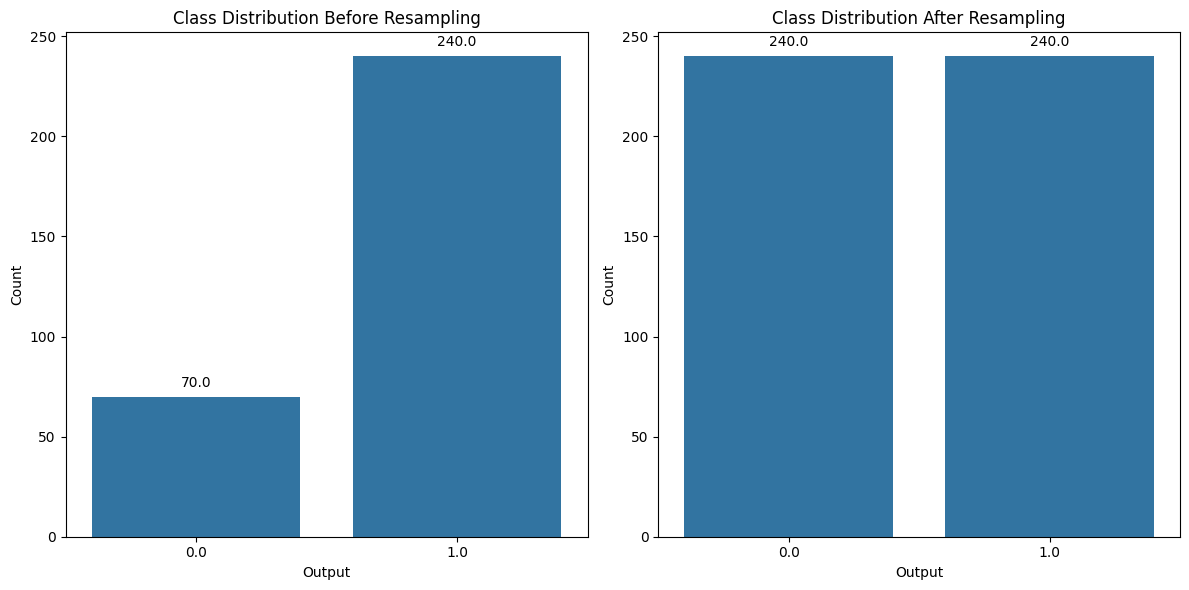

In [33]:
# Visualize the class distribution before and after resampling
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before resampling
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Class Distribution Before Resampling')
axes[0].set_xlabel('Output')
axes[0].set_ylabel('Count')

# Annotate bars
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# After resampling
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Class Distribution After Resampling')
axes[1].set_xlabel('Output')
axes[1].set_ylabel('Count')

# Annotate bars
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

In [34]:
final_df.to_csv('food_order.csv', index=False)